# Get Coordinates #

This script is used to get all the coordinates of each pose's keypoints and saves it into a CSV file.

### Import dependencies ###

In [10]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
import mediapipe as mp
from typing import List, Optional, Tuple
from mediapipe.framework.formats import landmark_pb2
from dataclasses import dataclass

### Resize image ###

In [2]:
DESIRED_HEIGHT = 800
DESIRED_WIDTH = 800

def resize(image):
    h, w = image.shape[:2]
    if h < w:
        return cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
    else:
        return cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))

### Import images ###

In [19]:
images = []

image1 = resize(cv2.imread("reference_pose/p_hidari_chudan_oi_zuki.png"))

images.append(image1)

### Run mediapipe ###

Nose coordinates: (landmark {
  x: 0.49082908034324646
  y: 0.30668821930885315
  z: -0.11429145932197571
  visibility: 0.9998937845230103
}
landmark {
  x: 0.49426159262657166
  y: 0.2987517714500427
  z: -0.10705620050430298
  visibility: 0.999894380569458
}
landmark {
  x: 0.49632593989372253
  y: 0.29868635535240173
  z: -0.10719028115272522
  visibility: 0.9998788833618164
}
landmark {
  x: 0.4983789026737213
  y: 0.29875439405441284
  z: -0.10715391486883163
  visibility: 0.9999146461486816
}
landmark {
  x: 0.4891824424266815
  y: 0.2984941899776459
  z: -0.09951601922512054
  visibility: 0.999893069267273
}
landmark {
  x: 0.48773545026779175
  y: 0.29819831252098083
  z: -0.0996532142162323
  visibility: 0.9998762607574463
}
landmark {
  x: 0.4862891137599945
  y: 0.29782700538635254
  z: -0.09972010552883148
  visibility: 0.9999083280563354
}
landmark {
  x: 0.5024814605712891
  y: 0.30015701055526733
  z: -0.05566601827740669
  visibility: 0.9998588562011719
}
landmark {
  x

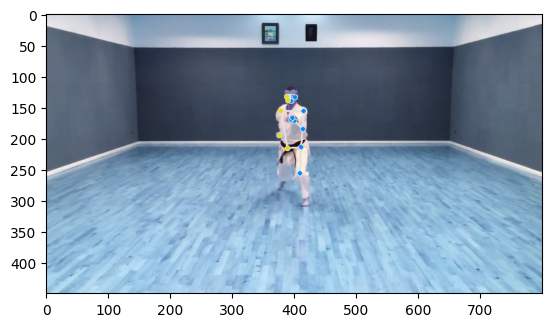

In [20]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.7, model_complexity=2) as pose:
    for image in images:
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        image_height, image_width, _ = image.shape
        if not results.pose_landmarks:
            continue
        
        print(
            f'Landmark Coordinates: ('
            f'{results.pose_landmarks})'
        )

        annotated_image = image.copy()
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        plt.imshow(annotated_image)

### Plot landmarks ###

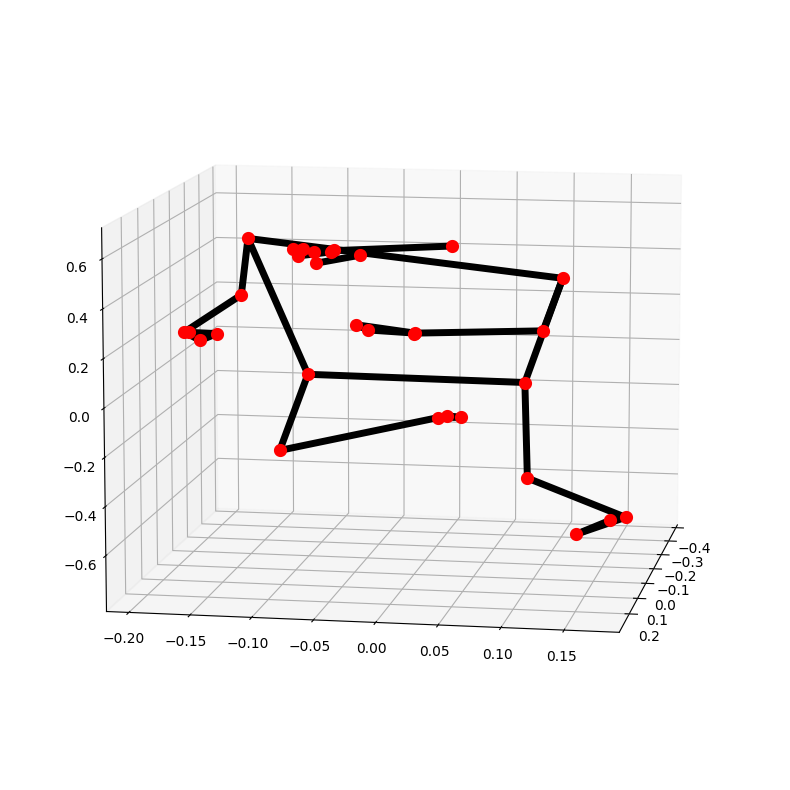

In [35]:
WHITE_COLOR = (224, 224, 224)
BLACK_COLOR = (0, 0, 0)
RED_COLOR = (0, 0, 255)

_PRESENCE_THRESHOLD = 0.05
_VISIBILITY_THRESHOLD = 0.05


@dataclass
class DrawingSpec:
    color: Tuple[int, int, int] = WHITE_COLOR
    thickness: int = 2
    circle_radius: int = 2


def _normalize_color(color):
    return tuple(v / 255. for v in color)


def plot_landmarks(landmark_list: landmark_pb2.NormalizedLandmarkList,
                   connections: Optional[List[Tuple[int, int]]] = None,
                   landmark_drawing_spec: DrawingSpec = DrawingSpec(
                       color=RED_COLOR, thickness=5),
                   connection_drawing_spec: DrawingSpec = DrawingSpec(
                       color=BLACK_COLOR, thickness=5),
                   elevation: int = 10,
                   azimuth: int = 10):

    """Plot the landmarks and the connections in matplotlib 3d.

    Args:
      landmark_list: A normalized landmark list proto message to be plotted.
      connections: A list of landmark index tuples that specifies how landmarks to
        be connected.
      landmark_drawing_spec: A DrawingSpec object that specifies the landmarks'
        drawing settings such as color and line thickness.
      connection_drawing_spec: A DrawingSpec object that specifies the
        connections' drawing settings such as color and line thickness.
      elevation: The elevation from which to view the plot.
      azimuth: the azimuth angle to rotate the plot.

    Raises:
      ValueError: If any connection contains an invalid landmark index.
    """
    
    if not landmark_list:
        return
    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.view_init(elev=elevation, azim=azimuth)
    plotted_landmarks = {}
    for idx, landmark in enumerate(landmark_list.landmark):
        if ((landmark.HasField('visibility') and
             landmark.visibility < _VISIBILITY_THRESHOLD) or
            (landmark.HasField('presence') and
             landmark.presence < _PRESENCE_THRESHOLD)):
            continue
        ax.scatter3D(
            xs=[-landmark.z],
            ys=[landmark.x],
            zs=[-landmark.y],
            color=_normalize_color(landmark_drawing_spec.color[::-1]),
            linewidth=landmark_drawing_spec.thickness)
        plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
    if connections:
        num_landmarks = len(landmark_list.landmark)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(f'Landmark index is out of range. Invalid connection '
                                 f'from landmark #{start_idx} to landmark #{end_idx}.')
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx], plotted_landmarks[end_idx]
                ]
                ax.plot3D(
                    xs=[landmark_pair[0][0], landmark_pair[1][0]],
                    ys=[landmark_pair[0][1], landmark_pair[1][1]],
                    zs=[landmark_pair[0][2], landmark_pair[1][2]],
                    color=_normalize_color(
                        connection_drawing_spec.color[::-1]),
                    linewidth=connection_drawing_spec.thickness)
    plt.show()

plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)